## This script compares age metrics among models that use uniform versus heterogeneous porosity.  The goal is to evaluate if and how complexity influences age metrics across scales.

#### The script reads in the model_grid.csv file for each model and uses that to tie each particle's initial location to select categories, such as the HUC, NLCD, coarse fraction, etc.  The model_grid.csv file was created via verion 2 of the general models / GRTD notebooks, tied to PFJ's repo called "GenMod" on the USGS GitLab site.

# This notebook is used to generate figure 9 of the FWP comparisons paper.

In [1]:
__author__ = 'Paul Juckem'
%matplotlib notebook
import os, sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import matplotlib.cm as cm
from datetime import datetime
import gdal
from gdal import ogr, osr
import gen_mod_functions as gm
import flopy as fp
import pickle
from ipywidgets import interact, Dropdown, Text
from IPython.display import display
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import csv

import fit_parametric_distributions

try:
    import rasterio
except:
    print('Install rasterio into your python environment. Or, skip plotting of geotiffs at the end of this notebook')

modifier = False
def ReturnEntry(sender):
    modifier.value = intext.value

## Specify user input, including list of models to compare and which axes to plot them, plus attributes to analyze.

In [10]:
#simulate_list = ['FWP1L_zK', 'FWP5L_zK', 'FWP5L_hK']  # list of models (w/ matching directory name) to analyze
#compare_list = ('FWP5L_zK', 'FWP5L_hK')  # compare these models directly; both uni_n and het_n versions.  Use a tuple to preserve order
evaluate = ('FWP5L_hK', 'FWP5L_zK')  # which two models to compare with color flooding of model factors.  1st minus 2nd, so order matters!
abrevdict = {'FWP5L_zK':'5zK', 'FWP5L_hK':'5hK'}

# This variable facilitates scenario testing (stopping or not at weak sinks/sources; porosity values & configuration, etc.)
#scenario_name = None  # set to None if no additional text was added to the modpath file names.
#scenario_name = 'passthroughsnk'  # an optional text string added to MP file names. MUST match value used in NB 01aa!!!
#scenario_name = 'het_n'  
scenario_name = 'het_n_1Dquad' #  1Dquad is the interpolation scheme

# when comparing results of the scenario to the base case, which weighting option to use? 'flux' or 'volume'
base_case = 'flux'

# for plotting 1:1 graphs
#x1, y1 = 0, 1  # index of names in the yet-to-be-populated eptlist variable.  (0=base case; 1 = scenario)

In [3]:
surf_aq_lays = 3  # deepest layer of the surficial aquifer.
nrow, ncol = 930, 650  # easier to hardcode this than waste the time to read-in a model just to get DIS info.

# for labeling RTD plots
label_by_model_name = True  # if false, will include zone info in label.

category = 'HUC8' 
age_cutoff = 65
minptl = 500  # The minimum number of particles for EACH model within each HUC (eg: if FWP5L has 2000, 
               # but FWP1L has 800, none get plotted in the 1:1 plots.  Still included in the RTD plots.)
               # 500-1000 seems reasonable for 1:1 plots as it includes only HUCs with really refined RTDs;
               # however, 100 - 500 seems more reasonable if we want to visualize spatial patterns because it
               # allows more HUCs to be plotted.  100-500 is based on visually inspecting RTD curves.
                
# Columns in the model_grid.csv file to keep.  Purge all others.
mg_columns = ['node_num', 'row', 'col', 'HUC6', 'HUC8', 'HUC10', 'HUC12', 'ibound', 'gage_id', 'coarse_flag', 
              'qu_atlas', 'catchment', 'ssurgo', 'stream_order', 'surfmat']
                
purge_hucs = [40602, 4060200, 406020000, 40602000000]  # all hucs for Lake Michigan      

HUCshpdict = {'HUC8':'E:/HUCS/WBD_4n7/WBD_HUC8_UTMft_FWPdomain.shp', 
              'HUC10':'E:/HUCS/WBD_4n7/WBD_HUC10_UTMft_FWPdomain.shp', 
              'HUC12':'E:/HUCS/WBD_4n7/WBD_HUC12_UTMft_FWPdomain.shp'}

HUCtiffdict = {'HUC8':'E:/HUCS/WBD_4n7/HUC8_UTMft_FWP.tiff', 
              'HUC10':'E:/HUCS/WBD_4n7/HUC10_UTMft_FWP.tiff',
              'HUC12':'E:/HUCS/WBD_4n7/HUC12_UTMft_FWP.tiff'}

dischargerastdict = {'FWP1L_zK': '../TIFFs/FWP1L_zK_SFRgain.tif', 'FWP5L_zK':'../TIFFs/FWP5L_zK_SFRgain.tif', 'FWP5L_hK':
                     '../TIFFs/FWP5L_hK_SFRgain.tif'}
lossrastdict = {'FWP1L_zK': '../TIFFs/FWP1L_zK_SFRloss.tif', 'FWP5L_zK':'../TIFFs/FWP5L_zK_SFRloss.tif', 'FWP5L_hK':
                     '../TIFFs/FWP5L_hK_SFRloss.tif'}

#### Prep the script for the models to be analyzed

In [4]:
homes = ['../Models']
fig_dir = '../Figures'

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

mfpth = '../executables/MODFLOW-NWT_1.0.9/bin/MODFLOW-NWT_64.exe'
mp_exe_name = '../executables/modpath.6_0/bin/mp6x64.exe' 

dir_list = []
modlist = []
i = 0
r = 0

path_dict = {}
dfdict = {}
totp = {}
for home in homes:
    if os.path.exists(home):
        for dirpath, dirnames, filenames in os.walk(home):
            for f in filenames:
                if os.path.splitext(f)[-1] == '.nam':
                    mod = os.path.splitext(f)[0]
                    i += 1
                    #if mod in compare_list:
                    if mod in evaluate:
                        modlist.append(mod)
                        dir_list.append(dirpath)
                        r += 1
                        path_dict[mod] = dirpath
                               
print('    {} models read'.format(i))
print('These {} models will be analyzed: {}'.format(r, modlist))

    19 models read
These 2 models will be analyzed: ['FWP5L_hK', 'FWP5L_zK']


In [5]:
# generate list of nam files:
nam_list = []
for pth in dir_list:
    model = os.path.normpath(pth).split(os.sep)[2]
    nam_file = '{}.nam'.format(model)
    nam_list.append(nam_file)

In [6]:
# setup dictionaries of the MODFLOW units for proper labeling of figures.
lenunit = {0:'undefined units', 1:'feet', 2:'meters', 3:'centimeters'}
timeunit = {0:'undefined', 1:'second', 2:'minute', 3:'hour', 4:'day', 5:'year'}

# Create dictionary of multipliers for converting model time units to days
time_dict = dict()
time_dict[0] = 1.0 # undefined assumes days, so enter conversion to days
time_dict[1] = 24 * 60 * 60
time_dict[2] = 24 * 60
time_dict[3] = 24
time_dict[4] = 1.0
time_dict[5] = 1.0

In [7]:
# Read-in model info and check max/min nlay & create list of DIS objects.  
# Assumes all else is the same among models (hnoflow, hdry, etc)
print ('Reading model information')
nlay_min = 100
nlay_max = 0

dis_objs = []
for i, model in enumerate(nam_list):
    nam_file = model
    model_ws = dir_list[i]
    
    fpmg = fp.modflow.Modflow.load(nam_file, model_ws=model_ws, exe_name=mfpth, version='mfnwt', 
                                   load_only=['DIS', 'BAS6', 'UPW', 'OC'], check=False)

    dis = fpmg.get_package('DIS')
    dis_objs.append(dis)
    bas = fpmg.get_package('BAS6')
    upw = fpmg.get_package('UPW')
    oc = fpmg.get_package('OC')

    delr = dis.delr
    delc = dis.delc
    nlay = dis.nlay
    nrow = dis.nrow
    ncol = dis.ncol
    bot = dis.getbotm()
    top = dis.gettop()

    hnoflo = bas.hnoflo
    ibound = np.asarray(bas.ibound.get_value())
    hdry = upw.hdry
    
    if nlay > nlay_max:
        nlay_max = nlay
    if nlay < nlay_min:
        nlay_min = nlay
        
    print('  .. done reading model {}'.format(i+1))

print ('   ... all done') 

print('minimum layers in a model:  {}'.format(nlay_min))
print('maximum layers in a model:  {}'.format(nlay_max))

Reading model information


C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\flopy\utils\util_array.py:2433: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if bintype is not None and not np.issubdtype(dtype, np.int):


  .. done reading model 1
  .. done reading model 2
   ... all done
minimum layers in a model:  5
maximum layers in a model:  5


## Process endpoint files and merge with model_grid.csv

In [8]:
def purge(ep_data):
    pre_Quaternary = ep_data.loc[ep_data.rt>=2.6e6]
    pre_Cretaceous = ep_data.loc[ep_data.rt>=66e6]
    preCambrian = ep_data.loc[ep_data.rt>=541e6]
    pre_earth = ep_data.loc[ep_data.rt>=4.6e9]

    print('\nFor your information:')
    print('{} particles were simulated as being older than Earth!'.format(preCambrian.shape[0]))
    print('{} particles were simulated as being PreCambrian in age.'.format(preCambrian.shape[0]))
    print('{} particles were simulated as being Cretaceous in age or older.'.format(pre_Cretaceous.shape[0]))
    print('{} particles were simulated as being pre-Quaternary in age.'.format(pre_Quaternary.shape[0]))
    
    ep_data = ep_data.loc[ep_data.rt<4.6e9]
    print('Purged particles older than earth')
    return(ep_data)

In [11]:
# read-in the model_grid.csv file for each model.  Then create a dataframe from each csv & pickle file.

dfdict = {}
totp = {}

for i, model in enumerate(evaluate):
#for i, model in enumerate(compare_list):
    g = os.path.join(path_dict[model], 'model_grid.csv')
    z = os.path.join(path_dict[model], 'zone_df.csv')
    try:
        df = pd.read_csv(g)
        df.ibound.replace(0, np.nan, inplace=True)
        df = df[df.ibound.notnull()]
        df = df[mg_columns]  # keep just the desired fields
        # re-calculate 2D cell number b/c node_num is computed differently for model_grid.csv and what's in the ept file.
        df['cellnum2d'] = df.row * ncol + df.col
        
        zone_df = pd.read_csv(z, index_col=0)
        for group in zone_df:
            print('\nReading-in the EPT file for {} in {}'.format(group, model))
            if scenario_name == None:
                print("Oops, I didn't really plan for this.  Stopping")
                sys.exit()
            else:
                p1 = os.path.join(path_dict[model], '{}_{}_{}.mpend'.format(model, base_case, group))
                p2 = os.path.join(path_dict[model], '{}_{}_{}_{}.mpend'.format(model, base_case, group, scenario_name))
                mnz1 = '{}_{}'.format(model, group)
                mnz2 = '{}_{}_{}'.format(model, group, scenario_name)
                eptu1 = fit_parametric_distributions.read_endpoints(p1, dis, time_dict)
                eptu2 = fit_parametric_distributions.read_endpoints(p2, dis, time_dict)
                
            eptu1 = purge(eptu1)
            eptu2 = purge(eptu2)
            eptu1['cellnum2d'] = (eptu1['Initial Row']-1) * ncol + (eptu1['Initial Column'] -1)  # -1 to convert to 0-based
            eptu2['cellnum2d'] = (eptu2['Initial Row']-1) * ncol + (eptu2['Initial Column'] -1)  # -1 to convert to 0-based
            eptu1_mg = eptu1.join(df, on='cellnum2d', lsuffix='_ept', rsuffix='_mg')
            eptu2_mg = eptu2.join(df, on='cellnum2d', lsuffix='_ept', rsuffix='_mg')
            eptu1_mg = eptu1_mg[eptu1_mg['Initial Layer'] <= surf_aq_lays]  # ensure that we're only analyzing Glacial!
            eptu2_mg = eptu2_mg[eptu2_mg['Initial Layer'] <= surf_aq_lays]  # ensure that we're only analyzing Glacial!

            #dfdict[model] = eptu_mg
            dfdict[mnz1] = eptu1_mg
            dfdict[mnz2] = eptu2_mg
            totp[mnz1] = eptu1_mg.rt.count()
            totp[mnz2] = eptu2_mg.rt.count()
            
            #x1 = eptlist[x1]  # pull out the file name after supplying the index
            #y1 = eptlist[y1]
            
    except (AttributeError, ValueError, IOError, IndexError):
        print('ERROR. THIS CODE BLOCK DID NOT COMPLETE. TROUBLE-SHOOT AND TRY AGAIN')
        print('The error occured while working on this model: {}'.format(model))
        raise SystemExit()

eptlist = list(dfdict.keys())
print('....done')

C:\Users\pfjuckem\AppData\Local\Continuum\miniconda3\envs\gis\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)



Reading-in the EPT file for zones[1] in FWP5L_hK

For your information:
0 particles were simulated as being older than Earth!
0 particles were simulated as being PreCambrian in age.
0 particles were simulated as being Cretaceous in age or older.
0 particles were simulated as being pre-Quaternary in age.
Purged particles older than earth

For your information:
0 particles were simulated as being older than Earth!
0 particles were simulated as being PreCambrian in age.
0 particles were simulated as being Cretaceous in age or older.
0 particles were simulated as being pre-Quaternary in age.
Purged particles older than earth

Reading-in the EPT file for zones[1] in FWP5L_zK

For your information:
0 particles were simulated as being older than Earth!
0 particles were simulated as being PreCambrian in age.
0 particles were simulated as being Cretaceous in age or older.
0 particles were simulated as being pre-Quaternary in age.
Purged particles older than earth

For your information:
0 parti

In [12]:
print(eptlist)
print(modlist)  # can't control the order of this one
print(evaluate)

['FWP5L_hK_zones[1]', 'FWP5L_hK_zones[1]_het_n_1Dquad', 'FWP5L_zK_zones[1]', 'FWP5L_zK_zones[1]_het_n_1Dquad']
['FWP5L_hK', 'FWP5L_zK']
('FWP5L_hK', 'FWP5L_zK')


In [ ]:
# Plot age distributions for uniform and heterogeneous porosity models by selected HUC

uniques = dfdict[eptlist[0]][category].unique()
# remove any HUCs listed in purge_hucs
for h in purge_hucs:
    ind = np.where(uniques==h)
    uniques = np.delete(uniques, ind)

n_uni = len(uniques)
sum_p = {}
for mn in eptlist:
    sum_p[mn] = 0
    
if n_uni <= 20:
    vplots = int(np.ceil(n_uni/ 3.0))
    figsize = (12, 3*vplots)
    CS, CSaxes = plt.subplots(vplots, 3, figsize=figsize)
else:
    hplots = int(np.round(np.sqrt(n_uni)))
    vplots = int(np.ceil(np.sqrt(n_uni)))
    figsize = (hplots*4, hplots*3)
    CS, CSaxes = plt.subplots(vplots, hplots, figsize=figsize)
        
colors_line = plt.cm.brg(np.linspace(0, 1, len(eptlist)))

for ax, cat_val in zip(CSaxes.flat, uniques):
    n = []
    for i, md in enumerate(eptlist):
        rt = dfdict[md].loc[dfdict[md][category]==cat_val, 'rt']  # 'rt' is "raw time" in the dataframe
        rt.sort_values(inplace=True)
        n.append(rt.count())
        sum_p[md] = sum_p[md] + rt.count()
        y_rt = np.linspace(0, 1, rt.shape[0])
    
        if label_by_model_name:
            label = eptlist[i]
        else:
            label = md
        ax.plot(rt, y_rt, c=colors_line[i], label=label)
        ax.plot((age_cutoff, age_cutoff), (0.2, 1), 'k--')
        
        title = '{}: {}'.format(category, cat_val)
        ax.set_title(title, fontsize=12)

        ax.set_xscale('log')
        ax.set_xlim(1e0, 1e3)
        ax.set_ylim(0, )

        ax.legend(loc=0, frameon=False, fontsize=8)#, bbox_to_anchor=(0.20, 0.2), ncol=1)
        ax.set_xlabel('Residence time, in years')
        ax.set_ylabel('Cumulative frequency')
        if len(n) == len(modlist):
            nmin, nmax = min(n), max(n)
            ax.text(5,0.02, '# particles: {:,} - {:,}'.format(nmin, nmax))
        
CS.suptitle('Comparison of glacial particle time distributions by {} for FWP scenarios'.format(category), fontsize=18)  
CS.tight_layout()

if n_uni < 18:
    #CS.subplots_adjust(top= 0.86, hspace=0.85)
    CS.subplots_adjust(top= 0.86)
elif n_uni < 100:
    CS.subplots_adjust(top= 0.93, hspace=0.55)
elif n_uni < 400:
    CS.subplots_adjust(top= 0.95, hspace=0.55)
else:
    CS.subplots_adjust(top= 0.97, hspace=0.55)

#dst = 'RTD_compare--{}_{}'.format(category, scenario_name)
#dst_pth = os.path.join(fig_dir, dst)
#plt.savefig(dst_pth)
#plt.close()

In [ ]:
# 1:1 plot of Young Fraction for uniform (X) versus heterogeneous (Y) porosity models by selected HUC

x1, y1, x2, y2 = eptlist[2], eptlist[3], eptlist[0], eptlist[1]  # columns in eptlist. In this case (x=uniform n; y = hetero n)

uniques = dfdict[eptlist[0]][category].unique()
# remove any HUCs listed in purge_hucs
for h in purge_hucs:
    ind = np.where(uniques==h)
    uniques = np.delete(uniques, ind)

yfhucdict = {}
yfvalues = []
skiphuc = []
for j, cat_val in enumerate(uniques):  # each HUC ID
    yfmoddict = {}
    for i, md in enumerate(eptlist):  # each of the 3 FWP models
        mn = eptlist[i]
        df = dfdict[md][dfdict[md][category]==cat_val].copy()
        if df.rt.count() >= minptl:
            youngdf = df.loc[df.rt < age_cutoff]
            yf = youngdf.rt.count() / df.rt.count()
            yfmoddict[mn] = yf
            yfvalues.append(yf)
        else:
            skiphuc.append(cat_val)
            break
    if cat_val not in skiphuc:
        yfhucdict[cat_val] = yfmoddict    
        
ddd = pd.DataFrame(yfhucdict).T
Prho_y1, Pp_y1 = stats.pearsonr(np.array(ddd[x1]), np.array(ddd[y1]))
Srho_y1, Sp_y1 = stats.spearmanr(np.array(ddd[x1]), np.array(ddd[y1]))
std_y1 = stats.tstd(np.array(ddd[x1]) - np.array(ddd[y1]))
ME_y1 = np.mean(np.array(ddd[x1]) - np.array(ddd[y1]))
Prho_y2, Pp_y2 = stats.pearsonr(np.array(ddd[x2]), np.array(ddd[y2]))
Srho_y2, Sp_y2 = stats.spearmanr(np.array(ddd[x2]), np.array(ddd[y2]))
std_y2 = stats.tstd(np.array(ddd[x2]) - np.array(ddd[y2]))
ME_y2 = np.mean(np.array(ddd[x2]) - np.array(ddd[y2]))

#plotting
mini = min(min(ddd[x1]), min(ddd[x2]), min(ddd[y1]), min(ddd[y2]))
maxi = max(max(ddd[x1]), max(ddd[x2]), max(ddd[y1]), max(ddd[y2]))
yrange = maxi-mini
ax = ddd.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', label='{}: uniform n vs heterogeneous n'.format(evaluate[1]))
ddd.plot(kind='scatter', x=x2, y=y2, marker='^', color='blue', label = '{}: uniform n vs heterogeneous n'.format(evaluate[0]), ax=ax)
lowlim = min(ax.get_xlim()[0], ax.get_ylim()[0])
uplim = max(ax.get_xlim()[1], ax.get_ylim()[1])
lims = (lowlim, uplim)
lrange = uplim - lowlim
ax.set_xlim(lims)  # force the plots to be square
ax.set_ylim(lims)
ax.plot((mini, maxi), (mini, maxi), 'k--')

plt.xlabel('Young Fraction from the uniform porosity models')
plt.ylabel('Young Fraction from the heterogeneous porosity models')
plt.suptitle('Comparison of glacial Young Fraction\n due to heterogeneous porosity, by {}'.format(category), fontsize=14)
#ax.text(0.76, maxi, 'R2 = {:3.3f}'.format(r2_y1), fontsize=9, color='green')
#ax.text(0.76, maxi-0.02, 'R2 = {:3.3f}'.format(r2_y2), fontsize=9, color='blue')
ax.text(lowlim+0.03*lrange, uplim-0.06*lrange, r'$r_p$ = {:3.3f}'.format(Prho_y1), fontsize=9, color='green')
ax.text(lowlim+0.03*lrange, uplim-0.11*lrange, r'$r_s$ = {:3.3f}'.format(Srho_y1), fontsize=9, color='green')
ax.text(lowlim+0.03*lrange, uplim-0.16*lrange, r'$std$ = {:3.3f}'.format(std_y1), fontsize=9, color='green')
ax.text(lowlim+0.03*lrange, uplim-0.21*lrange, r'$ME$ = {:3.3f}'.format(ME_y1), fontsize=9, color='green')
ax.text(lowlim+0.03*lrange, uplim-0.26*lrange, r'$r_p$ = {:3.3f}'.format(Prho_y2), fontsize=9, color='blue')
ax.text(lowlim+0.03*lrange, uplim-0.31*lrange, r'$r_s$ = {:3.3f}'.format(Srho_y2), fontsize=9, color='blue')
ax.text(lowlim+0.03*lrange, uplim-0.36*lrange, r'$std$ = {:3.3f}'.format(std_y2), fontsize=9, color='blue')
ax.text(lowlim+0.03*lrange, uplim-0.41*lrange, r'$ME$ = {:3.3f}'.format(ME_y2), fontsize=9, color='blue')
#plt.tight_layout()

dst = 'YFrac_121_compare_heteroN_{}'.format(category)
dst_pth = os.path.join(fig_dir, dst)
plt.savefig(dst_pth)
#plt.close()

In [ ]:
# 1:1 plot of Young Fraction for uniform (X) versus heterogeneous (Y) porosity for ALL HUC scales.

x1, y1, x2, y2 = eptlist[2], eptlist[3], eptlist[0], eptlist[1]  # columns in eptlist. In this case (x=uniform n; y = hetero n)
hucs = ['HUC6', 'HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axisdict = {0:ax1, 1:ax2, 2:ax3, 3:ax4}

for k, each in enumerate(hucs):
    # make sure we get ALL unique HUC IDs
    u1 = dfdict[eptlist[0]][each].unique()
    u2 = dfdict[eptlist[2]][each].unique()
    u = np.append(u1, u2)
    uniques = np.unique(u)
    # remove any HUCs listed in purge_hucs
    for h in purge_hucs:
        ind = np.where(uniques==h)
        uniques = np.delete(uniques, ind)
    axis = axisdict[k]

    yfhucdict = {}
    yfvalues = []
    skiphuc = []
    for j, cat_val in enumerate(uniques):  # each HUC ID
        yfmoddict = {}
        for i, md in enumerate(eptlist):  # each of the 3 FWP models
            mn = eptlist[i]
            df = dfdict[md].loc[dfdict[md][each]==cat_val]
            if df.rt.count() >= minptl:
                youngdf = df.loc[df.rt < age_cutoff]
                yf = youngdf.rt.count() / df.rt.count()
                yfmoddict[mn] = yf
                yfvalues.append(yf)
            else:
                skiphuc.append(cat_val)
                break
        if cat_val not in skiphuc:
            yfhucdict[cat_val] = yfmoddict    

    ddd = pd.DataFrame(yfhucdict).T
    Prho_y1, Pp_y1 = stats.pearsonr(np.array(ddd[x1]), np.array(ddd[y1]))
    Srho_y1, Sp_y1 = stats.spearmanr(np.array(ddd[x1]), np.array(ddd[y1]))
    std_y1 = stats.tstd(np.array(ddd[x1]) - np.array(ddd[y1]))
    ME_y1 = np.mean(np.array(ddd[x1]) - np.array(ddd[y1]))
    Prho_y2, Pp_y2 = stats.pearsonr(np.array(ddd[x2]), np.array(ddd[y2]))
    Srho_y2, Sp_y2 = stats.spearmanr(np.array(ddd[x2]), np.array(ddd[y2]))
    std_y2 = stats.tstd(np.array(ddd[x2]) - np.array(ddd[y2]))
    ME_y2 = np.mean(np.array(ddd[x2]) - np.array(ddd[y2]))
    
    #plotting
    mini = min(min(ddd[x1]), min(ddd[x2]), min(ddd[y1]), min(ddd[y2]))
    maxi = max(max(ddd[x1]), max(ddd[x2]), max(ddd[y1]), max(ddd[y2]))
    yrange = maxi-mini
    if k == 0:
        ddd.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', label='{}: uniform n vs heterogeneous n'.format(evaluate[1]), ax=axis)
        ddd.plot(kind='scatter', x=x2, y=y2, marker='^', color='blue', label = '{}: uniform n vs heterogeneous n'.format(evaluate[0]), ax=axis)
        axis.text(mini, mini+0.83*yrange, r'$r_p$ = {:3.3f}'.format(Prho_y1), fontsize=9, color='green')
        axis.text(mini, mini+0.78*yrange, r'$r_s$ = {:3.3f}'.format(Srho_y1), fontsize=9, color='green')
        axis.text(mini, mini+0.73*yrange, r'$std$ = {:3.3f}'.format(std_y1), fontsize=9, color='green')
        axis.text(mini, mini+0.68*yrange, r'$ME$ = {:3.3f}'.format(ME_y1), fontsize=9, color='green')
        axis.text(mini, mini+0.63*yrange, r'$r_p$ = {:3.3f}'.format(Prho_y2), fontsize=9, color='blue')
        axis.text(mini, mini+0.58*yrange, r'$r_s$ = {:3.3f}'.format(Srho_y2), fontsize=9, color='blue')
        axis.text(mini, mini+0.53*yrange, r'$std$ = {:3.3f}'.format(std_y2), fontsize=9, color='blue')
        axis.text(mini, mini+0.48*yrange, r'$ME$ = {:3.3f}'.format(ME_y2), fontsize=9, color='blue')
    else:
        ddd.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', ax=axis)
        ddd.plot(kind='scatter', x=x2, y=y2, marker='^', color='blue', ax=axis)
        axis.text(mini, mini+yrange, r'$r_p$ = {:3.3f}'.format(Prho_y1), fontsize=9, color='green')
        axis.text(mini, mini+0.95*yrange, r'$r_s$ = {:3.3f}'.format(Srho_y1), fontsize=9, color='green')
        axis.text(mini, mini+0.90*yrange, r'$std$ = {:3.3f}'.format(std_y1), fontsize=9, color='green')
        axis.text(mini, mini+0.85*yrange, r'$ME$ = {:3.3f}'.format(ME_y1), fontsize=9, color='green')
        axis.text(mini, mini+0.80*yrange, r'$r_p$ = {:3.3f}'.format(Prho_y2), fontsize=9, color='blue')
        axis.text(mini, mini+0.75*yrange, r'$r_s$ = {:3.3f}'.format(Srho_y2), fontsize=9, color='blue')
        axis.text(mini, mini+0.70*yrange, r'$std$ = {:3.3f}'.format(std_y2), fontsize=9, color='blue')
        axis.text(mini, mini+0.65*yrange, r'$ME$ = {:3.3f}'.format(ME_y2), fontsize=9, color='blue')    
    
    axis.plot((mini, maxi), (mini, maxi), 'k--')
    axis.set_xlabel(''), axis.set_ylabel('')
    axis.set_title(each)
    
    # Add an attribute to the HUC shapefile
    shapefile = HUCshpdict[each]
    shp = gpd.read_file(shapefile)  
    shp[each] = shp[each].astype('int64')  # convert so can merge
    ddd.index = ddd.index.astype('int64')  # convert so can merge
    ddd['YF_zK_uniVShet_n'.format(scenario_name, base_case)] = ddd[x1] - ddd[y1]
    ddd['YF_hK_uniVShet_n'.format(scenario_name, base_case)] = ddd[x2] - ddd[y2]

    df = pd.merge(shp, ddd, how='outer', left_on=each, right_index=True)
    dst = shapefile[:-4] + '_YF_{}.shp'.format(scenario_name)
    df.to_file(dst)

fig.text(0.5, 0.06, 'Young Fraction from the uniform porosity models', ha='center')
fig.text(0.06, 0.48, 'Young Fraction from the heterogeneous porosity models', va='center', rotation='vertical')
plt.subplots_adjust(top = .9)
fig.suptitle('Comparison of glacial aquifer Young Fractions\n by HUCs: uniform vs heterogeneous porosity.', fontsize=14)

dst = 'YFrac_121_uniVShet_n_allHUCS'
dst_pth = os.path.join(fig_dir, dst)
plt.savefig(dst_pth)
#plt.close()

# Figure 9 of FWP comparison paper.  Finalized on 3/20/2019

<IPython.core.display.Javascript object>


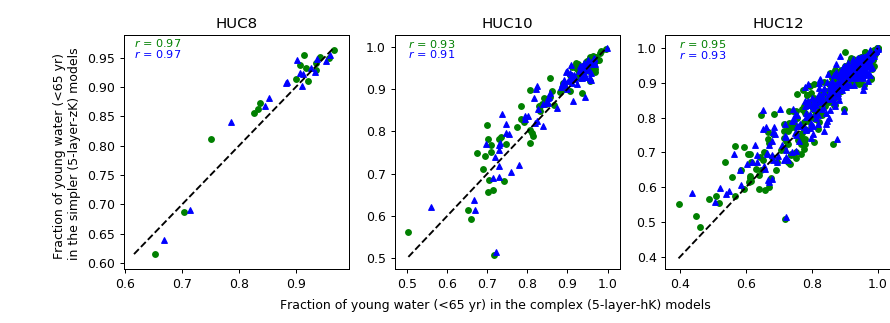

In [16]:
# 1:1 plot of Young Fraction for complex (X) versus simple (Y)  MF models for uniform and heterogeneous porosities for all HUC scales

# That is, we're testing to see if adding heterogeneous porosity increases or decreases the mis-match between simple and complexe MF models.
# If rho, std, & ME all improve or degrade, then that may indicate if age metrics from simple MF models can be improved by using texture to inform porosity.

x1, y1, x2, y2 = eptlist[0], eptlist[2], eptlist[1], eptlist[3]  # columns in eptlist. In this case (x=complexe MF; y=simple MF)
hucs = ['HUC8', 'HUC10', 'HUC12']
nhucs = len(hucs)
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(11, 4))
axisdict = {0:ax1, 1:ax2, 2:ax3}

for k, each in enumerate(hucs):
    # make sure we get ALL unique HUC IDs
    u1 = dfdict[eptlist[0]][each].unique()
    u2 = dfdict[eptlist[2]][each].unique()
    u = np.append(u1, u2)
    uniques = np.unique(u)
    # remove any HUCs listed in purge_hucs
    for h in purge_hucs:
        ind = np.where(uniques==h)
        uniques = np.delete(uniques, ind)
    axis = axisdict[k]

    yfhucdict = {}
    yfvalues = []
    skiphuc = []
    for j, cat_val in enumerate(uniques):  # each HUC ID
        yfmoddict = {}
        for i, md in enumerate(eptlist):  # each of the 3 FWP models
            mn = eptlist[i]
            df = dfdict[md].loc[dfdict[md][each]==cat_val]
            if df.rt.count() >= minptl:
                youngdf = df.loc[df.rt < age_cutoff]
                yf = youngdf.rt.count() / df.rt.count()
                yfmoddict[mn] = yf
                yfvalues.append(yf)
            else:
                skiphuc.append(cat_val)
                break
        if cat_val not in skiphuc:
            yfhucdict[cat_val] = yfmoddict    

    ddd = pd.DataFrame(yfhucdict).T
    Prho_y1, Pp_y1 = stats.pearsonr(np.array(ddd[x1]), np.array(ddd[y1]))
    ME_y1 = np.mean(np.array(ddd[x1]) - np.array(ddd[y1]))
    RMSE_y1 = np.sqrt(np.mean((np.array(ddd[x1]) - np.array(ddd[y1]))**2))
    Prho_y2, Pp_y2 = stats.pearsonr(np.array(ddd[x2]), np.array(ddd[y2]))
    ME_y2 = np.mean(np.array(ddd[x2]) - np.array(ddd[y2]))
    RMSE_y2 = np.sqrt(np.mean((np.array(ddd[x2]) - np.array(ddd[y2]))**2))
    
    #plotting
    mini = min(min(ddd[x1]), min(ddd[x2]), min(ddd[y1]), min(ddd[y2]))
    maxi = max(max(ddd[x1]), max(ddd[x2]), max(ddd[y1]), max(ddd[y2]))
    yrange = maxi-mini
    if k == 0:
        ddd.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', label= 'uniform porosity', ax=axis)
        ddd.plot(kind='scatter', x=x2, y=y2, marker='^', color='blue', label = 'hetero. porosity', ax=axis)
        axis.text(mini, mini+yrange, r'$r$ = {:3.2f}'.format(Prho_y1), fontsize=9, color='green')
        axis.text(mini, mini+0.95*yrange, r'$r$ = {:3.2f}'.format(Prho_y2), fontsize=9, color='blue')
        axis.legend(bbox_to_anchor=(0.5, 0.00), loc='lower center', bbox_transform=fig.transFigure, ncol=2)  # move the legend
        # below the plots.  https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    else:
        ddd.plot(kind='scatter', x=x1, y=y1, marker='o', color='green', ax=axis)
        ddd.plot(kind='scatter', x=x2, y=y2, marker='^', color='blue', ax=axis)
        axis.text(mini, mini+yrange, r'$r$ = {:3.2f}'.format(Prho_y1), fontsize=9, color='green')
        axis.text(mini, mini+0.95*yrange, r'$r$ = {:3.2f}'.format(Prho_y2), fontsize=9, color='blue') 
    
    axis.plot((mini, maxi), (mini, maxi), 'k--')
    axis.set_xlabel(''), axis.set_ylabel('')
    axis.set_title(each)
    
fig.text(0.5, 0.14, 'Fraction of young water (<65 yr) in the complex (5-layer-hK) models', ha='center')
fig.text(0.068, 0.57, 'Fraction of young water (<65 yr) \nin the simpler (5-layer-zK) models', va='center', ha='center', rotation='vertical')
plt.subplots_adjust(top = .9, bottom=0.25)  # make room for legend

dst = 'YFrac_121_hetn_hK2zK_3HUCS'
#dst = 'TEST.png'
dst_pth = os.path.join(fig_dir, dst)
plt.savefig(dst_pth)
#plt.close()

In [ ]:
dst_pth